# Exploratary data analysis 

In [23]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium 
from folium.plugins import HeatMap



In [3]:
from pyspark.sql import SparkSession

# Create a spark session with increased memory allocation
spark = (
    SparkSession.builder.appName("ADS Project1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Set the driver memory to 8GB
    .config("spark.executor.memory", "8g")  # Set the executor memory to 8GB
    .getOrCreate()
)

24/08/28 14:59:40 WARN Utils: Your hostname, Hanshis-Laptop.local resolves to a loopback address: 127.0.0.1; using 100.94.176.147 instead (on interface en0)
24/08/28 14:59:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/28 14:59:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/28 14:59:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/08/28 14:59:41 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/08/28 14:59:41 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
spark.conf.set("spark.sql.parquet.compression.codec","gzip")

In [7]:
# Load the data
df = spark.read.parquet("../data/curated/tlc_data/first_cleaned.parquet/")

## Summary Statistics 

In [8]:
# Drop rows with any missing values
clean_df = df.dropna()

# Check the number of remaining rows
remaining_rows = clean_df.count()
total_rows = df.count()

print(f"Remaining rows after dropping missing values: {remaining_rows} out of {total_rows}")
# print percentage of rows remaining
print(f"Percentage of rows remaining: {remaining_rows/total_rows*100:.2f}%")


24/08/28 15:00:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Remaining rows after dropping missing values: 21959390 out of 22294112
Percentage of rows remaining: 98.50%


In [9]:
# print the schema
clean_df.printSchema()

root
 |-- DOLocationID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- DOBorough: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nulla

In [30]:
# summary statistics
clean_df.summary().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-------------+-------------+-------------------+------------------+------------------+-------------------+-----------------+------------------+---------------------+------------------+--------------------+---------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|      DOLocationID|      PULocationID|       pickup_hour|      dropoff_hour|           VendorID|   passenger_count|    trip_distance|     trip_duration|        RatecodeID|    PUBorough|    DOBorough|       payment_type|       fare_amount|             extra|            mta_tax|       tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|ehail_fee|hourly_trip_count|  daily_trip_count|   

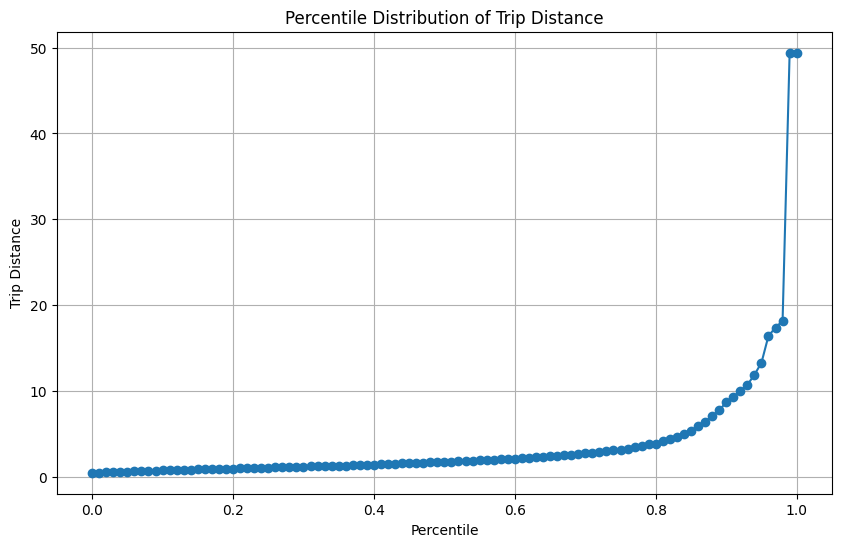

In [29]:
# Generate percentiles
percentiles = np.arange(0, 1.01, 0.01).tolist()  # Convert NumPy array to list

# Calculate approximate quantiles for trip_distance
percentile_trip_distance = clean_df.approxQuantile("trip_distance", percentiles, 0.01)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(percentiles, percentile_trip_distance, marker='o')
plt.xlabel('Percentile')
plt.ylabel('Trip Distance')
plt.title('Percentile Distribution of Trip Distance')
plt.grid(True)
plt.show()


In [11]:
# Group by pickup_hour and PUBorough to get the sum of trips, and average weather data
hourly_demand = clean_df.groupBy('pickup_hour', 'PUBorough').agg(
    F.sum('hourly_trip_count').alias('total_hourly_trips'),
    F.mean('TMP').alias('avg_temperature'),
    F.mean('VIS').alias('avg_visibility'),
    F.sum('Number of Events').alias('total_events')
)

# Show the aggregated result
hourly_demand.show()

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=27089Kb max_used=27089Kb free=103982Kb
 bounds [0x000000010a9e8000, 0x000000010c488000, 0x00000001129e8000]
 total_blobs=10149 nmethods=9158 adapters=904
 compilation: disabled (not enough contiguous free space left)


+-----------+-------------+------------------+------------------+------------------+------------+
|pickup_hour|    PUBorough|total_hourly_trips|   avg_temperature|    avg_visibility|total_events|
+-----------+-------------+------------------+------------------+------------------+------------+
|         17|       Queens|         785521638| 10.93664068833268|1330.5261158513363|       80038|
|          8|        Bronx|            999449| 8.145149253731342| 1274.835074626866|        1184|
|          4|       Queens|           4795238| 414.1079073005803| 41605.33510045694|          94|
|          2|     Brooklyn|           3559773| 8.414424410540903|1453.8959084604678|         164|
|          9|       Queens|         312004036| 7.568226049374633|1271.1091022199291|      271834|
|         21|    Manhattan|        6310800097|10.048079213548753| 1308.768446728925|      184699|
|         12|       Queens|         531505543| 8.363961545969284|1187.6475590475527|      132791|
|         14|Staten 

In [12]:
# Group by pickup_date and PUBorough to get the sum of trips and average weather data
daily_demand = clean_df.groupBy('pickup_date', 'PUBorough').agg(
    F.sum('daily_trip_count').alias('total_daily_trips'),
    F.mean('TMP').alias('avg_temperature'),
    F.mean('VIS').alias('avg_visibility'),
    F.sum('Number of Events').alias('total_events')
)

# Show the aggregated result
daily_demand.show()

+-----------+-------------+-----------------+-------------------+------------------+------------+
|pickup_date|    PUBorough|total_daily_trips|    avg_temperature|    avg_visibility|total_events|
+-----------+-------------+-----------------+-------------------+------------------+------------+
| 2024-03-01|        Bronx|          3199776|  34.11249999999999| 4684.006249999998|          56|
| 2024-02-20|     Brooklyn|         16177744| 0.3828877005347596|1609.2999999999943|         399|
| 2023-12-04|    Manhattan|       7744398945| 12.350321848693522|1826.1677649722944|      304222|
| 2023-12-04|     Brooklyn|         20439627| 13.952488687782832| 1965.485972850669|         474|
| 2024-01-03|          EWR|            74255|                1.7|            1609.3|           0|
| 2023-12-25|    Manhattan|       2197615420|  10.43478376463068| 1135.818261255422|      100031|
| 2024-03-07|     Brooklyn|         42887936|  12.85336538461535|1668.4495192307766|         647|
| 2024-02-18|       

In [21]:
# Load a shapefile of NYC boroughs (replace with your shapefile path)
nyc_boroughs = gpd.read_file("../data/landing/external/geo_export_f16e615f-62c7-40bb-856c-2cccde28f16b.shp")
# check the first 5 rows
nyc_boroughs.head(5)

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.695, -74.18449 40.69509..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [ ]:
# Example data extraction for Folium (needs latitude and longitude)
# Replace with actual latitude and longitude values for each borough
location_data = clean_df.select('PUBorough', 'hourly_trip_count').rdd.map(lambda row: [latitude, longitude, row['hourly_trip_count']]).collect()

# Create a map centered on NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add heatmap
HeatMap(location_data).add_to(m)

# Display the map
m


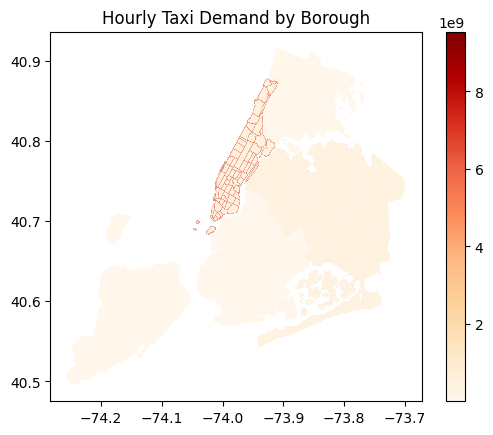

In [22]:
# Merge with the aggregated demand data
borough_demand = nyc_boroughs.merge(hourly_demand.toPandas(), left_on='borough', right_on='PUBorough')

# Plotting the choropleth
borough_demand.plot(column='total_hourly_trips', cmap='OrRd', legend=True)
plt.title('Hourly Taxi Demand by Borough')
plt.show()

## Distribution Analysis 

## Categorical Data Analysis

## Correlation Analysis 

In [31]:
# Calculate correlation values
temp_corr_value = clean_df.stat.corr('TMP', 'hourly_trip_count')
vis_corr_value = clean_df.stat.corr('VIS', 'hourly_trip_count')
events_corr_value = clean_df.stat.corr('Number of Events', 'hourly_trip_count')

In [25]:
# Calculate correlation between weather variables and hourly demand
correlations = clean_df.select(
    F.corr('TMP', 'hourly_trip_count').alias('temp_corr'),
    F.corr('VIS', 'hourly_trip_count').alias('vis_corr'),
    F.corr('Number of Events', 'hourly_trip_count').alias('events_corr')
)

# Show correlation results
correlations.show()

+--------------------+--------------------+--------------------+
|           temp_corr|            vis_corr|         events_corr|
+--------------------+--------------------+--------------------+
|-0.14284978763651862|-0.15753141366696694|-0.10885282012569461|
+--------------------+--------------------+--------------------+



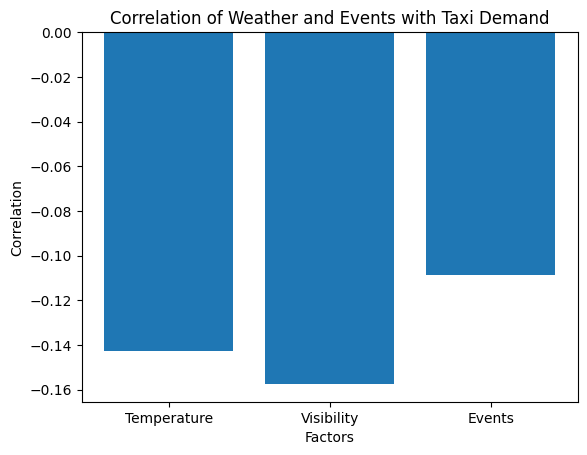

In [32]:
# Example correlation values (replace with actual values from the previous step)
correlations = {
    'Temperature': temp_corr_value,
    'Visibility': vis_corr_value,
    'Events': events_corr_value
}

plt.bar(correlations.keys(), correlations.values())
plt.title('Correlation of Weather and Events with Taxi Demand')
plt.xlabel('Factors')
plt.ylabel('Correlation')
plt.show()

## Bivariate Analysis